In [3]:
# initial dataframe from the cleaned data in silver layer
import pandas as pd
from pathlib import Path

silver_path = Path.cwd().parent / 'data' / 'silver' / 'creditcard_fraud_cleaned.parquet'

df = pd.read_parquet(silver_path)
print(df.shape)
df.head(3)

(283726, 31)


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
# splitting dataset in X(independent features) and y (target class)

X = df.drop(columns='class')
y = df['class']
(y.value_counts()/y.shape[0])*100

class
0    99.83329
1     0.16671
Name: count, dtype: float64

In [5]:
# all the dataset is already scaled with pca transform, except for time and amount
# so before splitting and training the dataset,let's scale:
# time using minMaxscaler, which is standard
# amount using robustScaler, to better treat the significant rigth skewness and outliers

from sklearn.preprocessing import MinMaxScaler, RobustScaler
time_scaler = MinMaxScaler()
amount_scaler = RobustScaler()
X['time_scaled'] = time_scaler.fit_transform(X[['time']])
X['amount_scaled'] =amount_scaler.fit_transform(X[['amount']])
X[['amount_scaled','time_scaled']].describe()

,amount_scaled,time_scaled
count,283726.000000,283726.000000
mean,0.924387,0.548701
std,3.482123,0.274787
min,-0.305938,0.000000
25%,-0.228063,0.313699
50%,0.000000,0.490141
75%,0.771937,0.806160
max,356.962314,1.000000


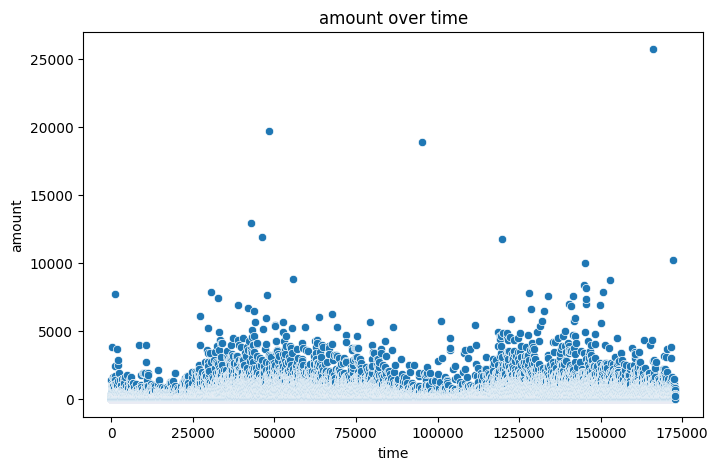

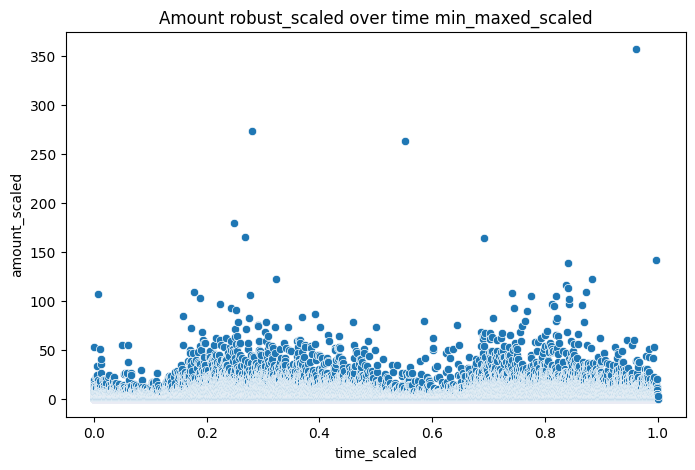

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.scatterplot(data = X, x='time', y='amount')
plt.title('amount over time')
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data = X, x='time_scaled', y='amount_scaled')
plt.title('Amount robust_scaled over time min_maxed_scaled')
plt.show()


In [6]:
# splitting the data in training and testing, using stratify to keep the proportions and not bias the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

In [8]:
# lets check the data splitting (this could be a function in the ML pipeline) (still simillar proportion)
print('how many frauds and non frauds in the test split\n',y_train.value_counts())
print()
print((y_train.value_counts()/y_train.shape[0])*100)

how many frauds and non frauds in the test split
 class
0    226602
1       378
Name: count, dtype: int64

class
0    99.833466
1     0.166534
Name: count, dtype: float64


In [7]:
# as this is a binary classification problem (it has two classes, positive, fraud, and negative, non-fraud)
# a logistic classifier is more apropriate
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(class_weight='balanced',random_state=11037, max_iter=400)

In [29]:
# preparing the training data (and keeping test data equivalent)
X_train = X_train.drop(columns=['time','amount'])
X_test = X_test.drop(columns=['time','amount'])
X_train.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,time_scaled,amount_scaled
53653,1.446510,-1.408523,0.996297,-1.198740,-1.970052,-0.090232,-1.589122,0.083469,-0.908384,1.261312,...,-0.269452,-0.277609,-0.006431,-0.142243,0.285835,-0.164243,0.070584,0.029803,0.267350,0.166875
251122,1.889580,-0.384057,-0.406803,2.021087,-0.255107,0.588065,-0.604542,0.228356,-0.015186,1.113616,...,0.038670,0.263423,0.190192,0.890541,-0.421333,2.323311,-0.183850,-0.079624,0.900661,0.108886
99775,1.211725,0.345265,0.190318,0.923116,0.015686,-0.432605,0.175002,-0.115032,-0.383358,0.156299,...,0.071556,0.244346,-0.168191,0.039148,0.727314,-0.329102,0.013706,0.009884,0.390261,-0.148797


## 🧠 Why Logistic Regression for the Baseline?
Logistic Regression is a simple, interpretable model that gives us a **baseline** for detecting fraud.
It's useful for benchmarking because:

- It requires minimal hyperparameter tuning.
- Its coefficients can indicate feature importance.
- However, **Logistic Regression is sensitive to feature scaling**, so we preprocess `time` and `amount`.

---

## ⚠️ Class Imbalance in Fraud Detection
The dataset is **highly imbalanced**:
- Class 0 (Non-Fraud): ~99.8%
- Class 1 (Fraud): ~0.2%

This means **accuracy** is a **bad metric** (a model predicting "no fraud" every time would still be right 99.8% of the time). Instead, we use metrics that focus on the minority class.

---

## 📏 Key Metrics for Imbalanced Data
| Metric            | Why It Matters                                                        |
|--------------------|------------------------------------------------------------------------|
| **Precision**      | Of all predicted fraud cases, how many were correct?                 |
| **Recall (Sensitivity)** | Of all actual fraud cases, how many did we detect?                  |
| **F1-score**       | Harmonic mean of Precision and Recall (balances false positives and negatives). |
| **ROC AUC**        | Measures model's ability to separate classes across thresholds.      |
| **PR AUC**         | Precision-Recall AUC focuses on the minority class (more informative for imbalanced data). |
| **Balanced Accuracy** | Adjusts accuracy to account for class imbalance.                  |

We’ll compute all of these using cross validate and stratified k-fold.

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold

In [11]:
# define scorers
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',  # threshold=0.5
    'recall': 'recall',        # threshold=0.5
    'f1': 'f1',                # threshold=0.5
    'roc_auc': 'roc_auc',      # needs probabilities for it to be based on all threshold
    'pr_auc': 'average_precision',  # needs probabilities
    'balanced_accuracy': 'balanced_accuracy',
}

In [12]:
# define stratified CV to preserve fraud/non-fraud ratio in all folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11037)

In [ ]:
# perform cross-validation
cv_results = cross_validate(
    log_clf,
    X_train, y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,

)
results_df = pd.DataFrame(cv_results).mean()

In [10]:
results_df

fit_time                  1.320863
score_time                0.062022
test_accuracy             0.974403
test_precision            0.056124
test_recall               0.907333
test_f1                   0.105695
test_roc_auc              0.978309
test_pr_auc               0.733511
test_balanced_accuracy    0.940924
dtype: float64

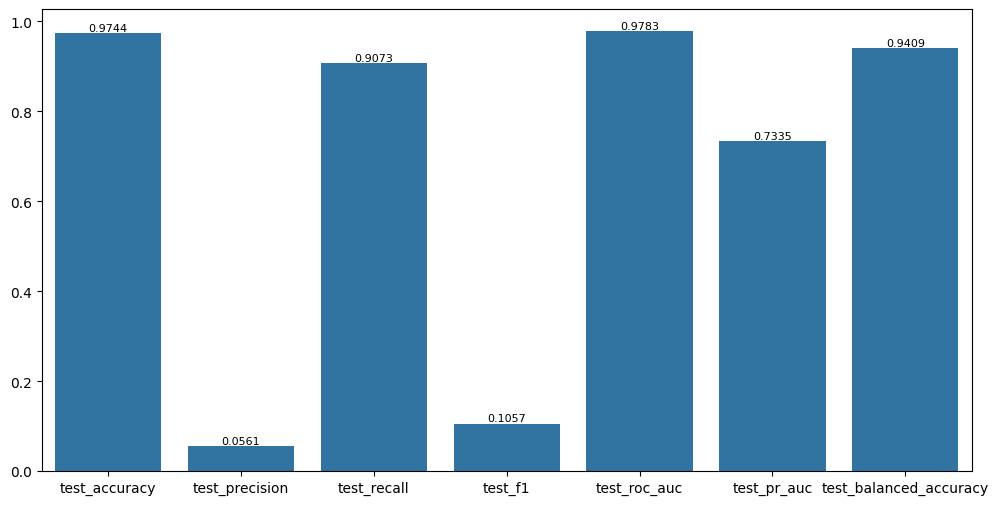

In [11]:
plt.figure(figsize=(12,6))
base_model_scores_barplot = sns.barplot(results_df.loc['test_accuracy':])


for patch in base_model_scores_barplot.patches:
    height = patch.get_height()
    if height > 0:
        base_model_scores_barplot.annotate(f'{height:.4f}',  # formatting
            (patch.get_x() + patch.get_width() / 2, height), # setting each coordinate to be on the patch
            ha='center', va='bottom', fontsize=8, rotation=0) # position related to the patch cordinate, right above and center


plt.show()

In [12]:
log_clf.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 400,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 11037,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# Lets remember the features most correlated to target class (fraud)
this will be the base for:

feature selection

feature engineering

feature dropping

In [13]:
# 📊 Correlation with target
correlations = X_train.copy()
correlations['target'] = y_train

corr_matrix = correlations.corr()
target_corr = corr_matrix['target'].drop('target').sort_values(key=abs, ascending=False)

# Display sorted correlations
target_corr


v17             -0.307034
v14             -0.292266
v12             -0.249096
v10             -0.205663
v16             -0.184426
v3              -0.181268
v7              -0.169339
v11              0.149222
v4               0.128972
v18             -0.102175
v1              -0.093558
v9              -0.092142
v5              -0.084323
v2               0.081772
v6              -0.043575
v19              0.032247
v8               0.029171
v21              0.026580
v27              0.021475
v20              0.020871
time_scaled     -0.011896
v28              0.009042
v23             -0.007279
v24             -0.006729
amount_scaled    0.006431
v22              0.004588
v26              0.004270
v25              0.003662
v15             -0.003380
v13             -0.003346
Name: target, dtype: float64

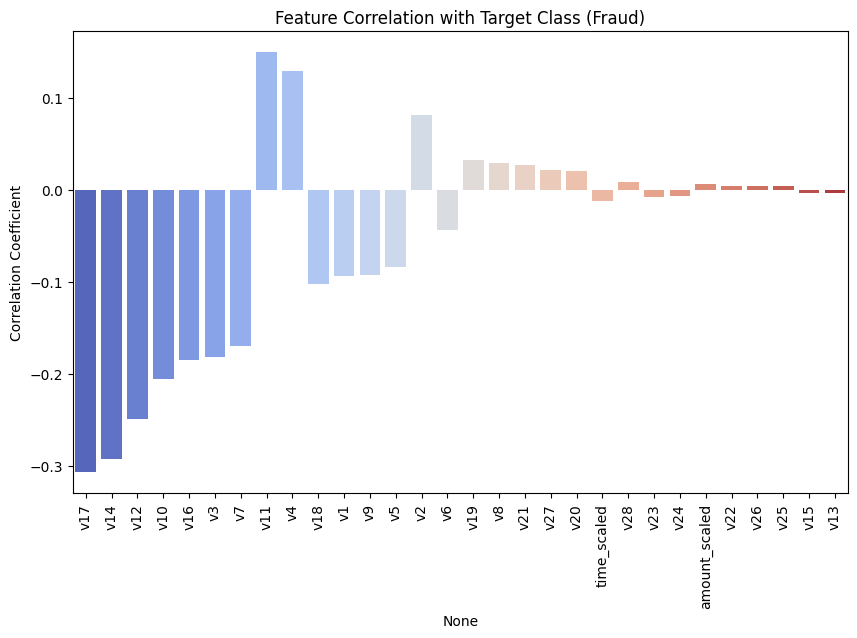

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.index, y=target_corr.values,hue=target_corr.index,legend=False, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Feature Correlation with Target Class (Fraud)")
plt.ylabel("Correlation Coefficient")
plt.show()

In [15]:
from sklearn.model_selection import cross_val_score

used_features = []
scores = []

for f in target_corr.index:
    used_features.append(f)

    log_temp = LogisticRegression(class_weight='balanced', max_iter=400, random_state=11037)

    # 5-fold CV and F1 score (for imbalance)
    cv_scores = cross_val_score(
        log_temp,
        X_train[used_features],
        y_train,
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )

    mean_score = cv_scores.mean()
    scores.append(mean_score)

    print(f"Added Feature: {f} | F1-Score: {mean_score:.4f}")


Added Feature: v17 | F1-Score: 0.5894
Added Feature: v14 | F1-Score: 0.1118
Added Feature: v12 | F1-Score: 0.1061
Added Feature: v10 | F1-Score: 0.1150
Added Feature: v16 | F1-Score: 0.1166
Added Feature: v3 | F1-Score: 0.1134
Added Feature: v7 | F1-Score: 0.1156
Added Feature: v11 | F1-Score: 0.1174
Added Feature: v4 | F1-Score: 0.1111
Added Feature: v18 | F1-Score: 0.1095
Added Feature: v1 | F1-Score: 0.1087
Added Feature: v9 | F1-Score: 0.1089
Added Feature: v5 | F1-Score: 0.1047
Added Feature: v2 | F1-Score: 0.1050
Added Feature: v6 | F1-Score: 0.1069
Added Feature: v19 | F1-Score: 0.1069
Added Feature: v8 | F1-Score: 0.1109
Added Feature: v21 | F1-Score: 0.1097
Added Feature: v27 | F1-Score: 0.1092
Added Feature: v20 | F1-Score: 0.1087
Added Feature: time_scaled | F1-Score: 0.1115
Added Feature: v28 | F1-Score: 0.1116
Added Feature: v23 | F1-Score: 0.1079
Added Feature: v24 | F1-Score: 0.1077
Added Feature: amount_scaled | F1-Score: 0.1079
Added Feature: v22 | F1-Score: 0.1043
Add

## 🔍 Forward Feature Selection with Logistic Regression

To explore the contribution of individual features to model performance, we performed a forward feature selection procedure. At each step, we added the next most-correlated feature to the model and computed the mean F1-score using 5-fold cross-validation.

The results show:

- The first feature alone achieves a very high F1-score (~0.65).
- Adding additional features leads to a sharp performance drop and does not improve results significantly.
- This suggests that the first feature captures most of the fraud signal for a linear model like Logistic Regression.

This behavior is expected because:
- Most features are PCA-transformed and orthogonal, meaning they are uncorrelated by construction.
- Logistic Regression may struggle to separate classes in PCA space.

The plot below illustrates this trend.


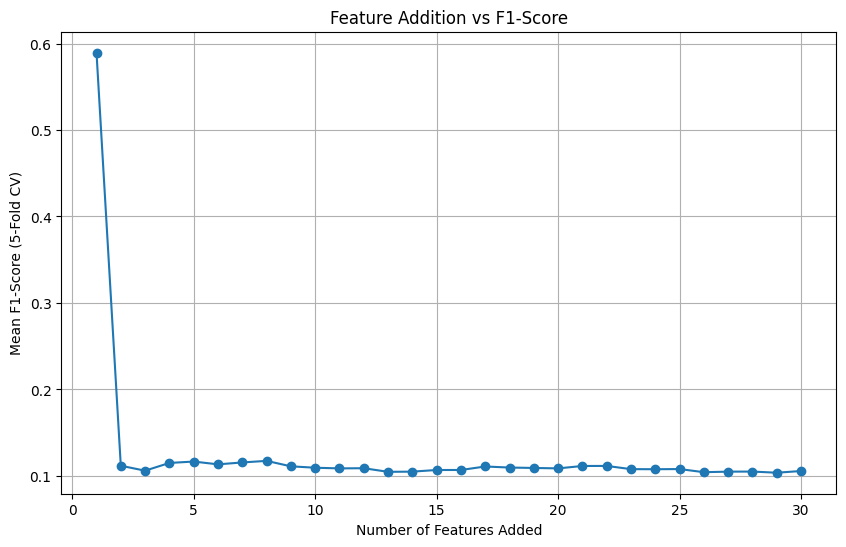

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.title("Feature Addition vs F1-Score")
plt.xlabel("Number of Features Added")
plt.ylabel("Mean F1-Score (5-Fold CV)")
plt.grid(True)
plt.show()

In [17]:
log_v17_clf = LogisticRegression(class_weight='balanced', max_iter=400, random_state=11037)
# perform cross-validation with full metrics on v17 only
cv_v17_results = cross_validate(
    log_v17_clf,
    X_train[['v17']], y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False
)
results_v17_df = pd.DataFrame(cv_v17_results).mean()

In [18]:
results_v17_df

fit_time                  0.100793
score_time                0.035632
test_accuracy             0.998365
test_precision            0.506445
test_recall               0.708947
test_f1                   0.589353
test_roc_auc              0.790702
test_pr_auc               0.595468
test_balanced_accuracy    0.853898
dtype: float64

In [50]:
def plot_bar_metrics(score_df: pd.DataFrame):
    plt.figure(figsize=(12,6))
    model_scores_barplot = sns.barplot(score_df.loc['test_accuracy':])


    for patch in model_scores_barplot.patches:
        height = patch.get_height()
        if height > 0:
            model_scores_barplot.annotate(f'{height:.4f}',  # formatting
                (patch.get_x() + patch.get_width() / 2, height), # setting each coordinate to be on the patch
                ha='center', va='bottom', fontsize=8, rotation=0) # position related to the patch cordinate, right above and center


    plt.show()

plot_bar_metrics(results_v17_df)

NameError: name 'results_v17_df' is not defined

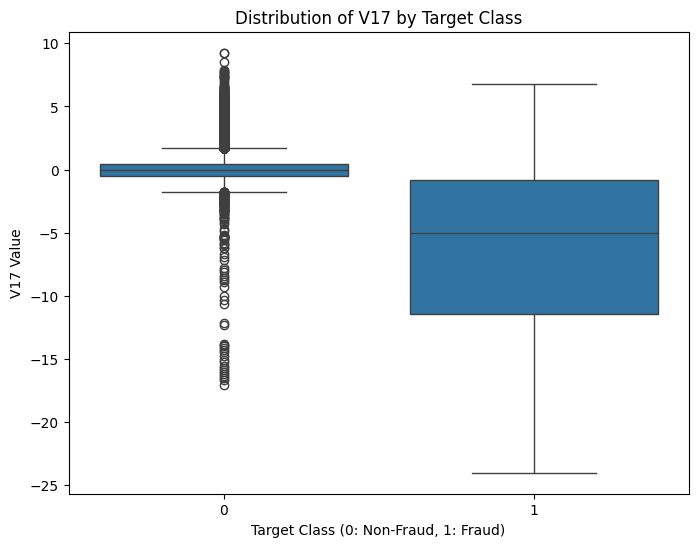

In [20]:


plt.figure(figsize=(8, 6))
sns.boxplot(x=y_train, y=X_train['v17'])
plt.title("Distribution of V17 by Target Class")
plt.xlabel("Target Class (0: Non-Fraud, 1: Fraud)")
plt.ylabel("V17 Value")
plt.show()

In [47]:
from xgboost import XGBClassifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

bst_clf_parameters = {
    'clf__max_depth':[10, 50, None], 
    'clf__n_estimators':[2, 15, 50], 
    'clf__learning_rate':[0.1, 1, 15],
}


In [96]:
bst_rand_search = RandomizedSearchCV(
    XGBClassifier(random_state=11037, n_jobs=-1,verbosity=0),
    param_distributions=bst_clf_parameters,
    scoring='f1',
    n_iter=10,
    cv=cv,
    random_state=11037
)

bst_rand_search.fit(X_train,y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'clf__learning_rate': [0.1, 1, ...], 'clf__max_depth': [10, 50, ...], 'clf__n_estimators': [2, 15, ...]}"
,n_iter,10
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,11037
,error_score,nan


In [97]:
print("Best parameters:", bst_rand_search.best_params_)
print("F1 score for top model: ", bst_rand_search.best_score_)

Best parameters: {'clf__n_estimators': 15, 'clf__max_depth': None, 'clf__learning_rate': 15}
F1 score for top model:  0.8126124254546889


In [102]:


bst_clf = XGBClassifier(
    n_estimators=15, 
    max_depth=None, 
    learning_rate=15, 
    )


In [103]:
bst_clf_results = cross_validate(
    bst_clf,
    X_train, y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False
)

In [104]:
bst_clf_results_df = pd.DataFrame(bst_clf_results).mean()

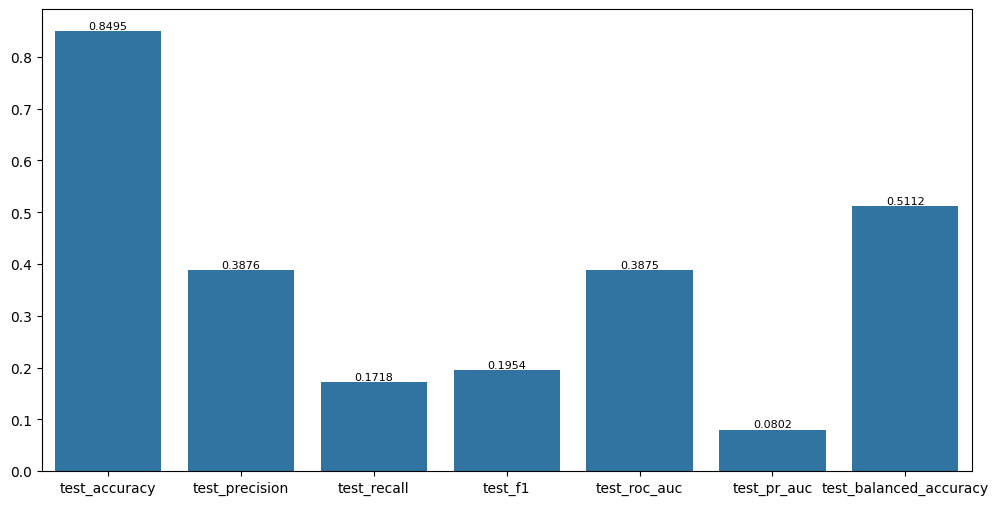

In [105]:
plot_bar_metrics(bst_clf_results_df)

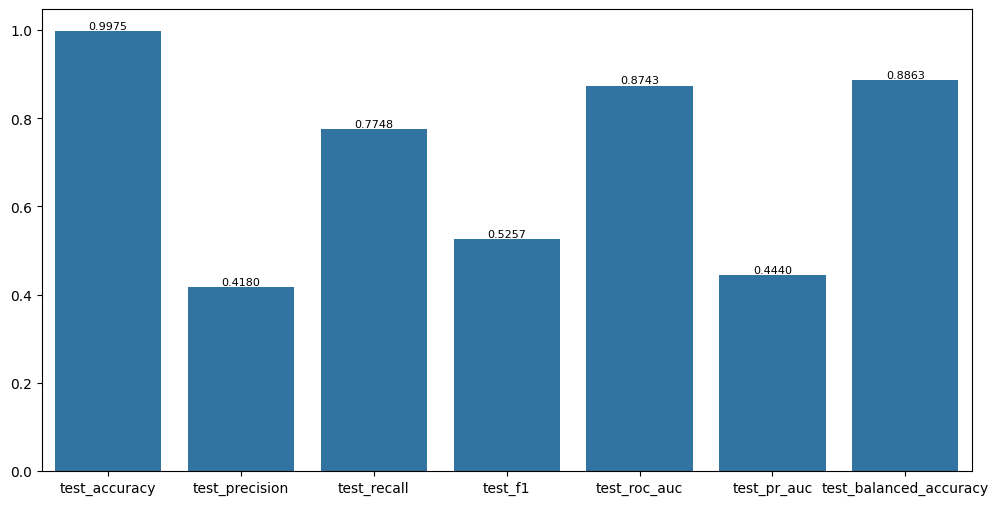

In [56]:
plot_bar_metrics(bst_clf_results_df)

## 🌲 Random Forest Classifier With Feature Importances

To explore non-linear patterns and potential feature interactions, we train a Random Forest Classifier using all PCA-transformed features and the scaled `Amount` and `Time`.  

Random Forest is a tree-based ensemble method that:  
- Handles imbalanced datasets better than linear models.  
- Provides a direct estimate of feature importances.  

We train the model using 5-fold cross-validation and compute the same evaluation metrics as before.


In [2]:
# importing 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate


In [ ]:
# ⚙️ Random Forest model
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',  # Handle class imbalance
    random_state=11037,
    n_jobs=-1
)

# 📊 Evaluate model
rf_cv_results = cross_validate(
    rf_clf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# 📄 Display mean CV scores
for metric, scores in rf_cv_results.items():
    if metric.startswith("test_"):
        print(f"{metric}: {scores.mean():.6f}")

results_rand_tree_df = pd.DataFrame(rf_cv_results)


test_accuracy: 0.999502
test_precision: 0.942998
test_recall: 0.745965
test_f1: 0.831276
test_roc_auc: 0.938995
test_pr_auc: 0.830663
test_balanced_accuracy: 0.872945


In [22]:
results_rand_tree_df = pd.DataFrame(rf_cv_results).mean(numeric_only=True)
results_rand_tree_df.loc['test_accuracy':]

test_accuracy             0.999502
test_precision            0.942998
test_recall               0.745965
test_f1                   0.831276
test_roc_auc              0.938995
test_pr_auc               0.830663
test_balanced_accuracy    0.872945
dtype: float64

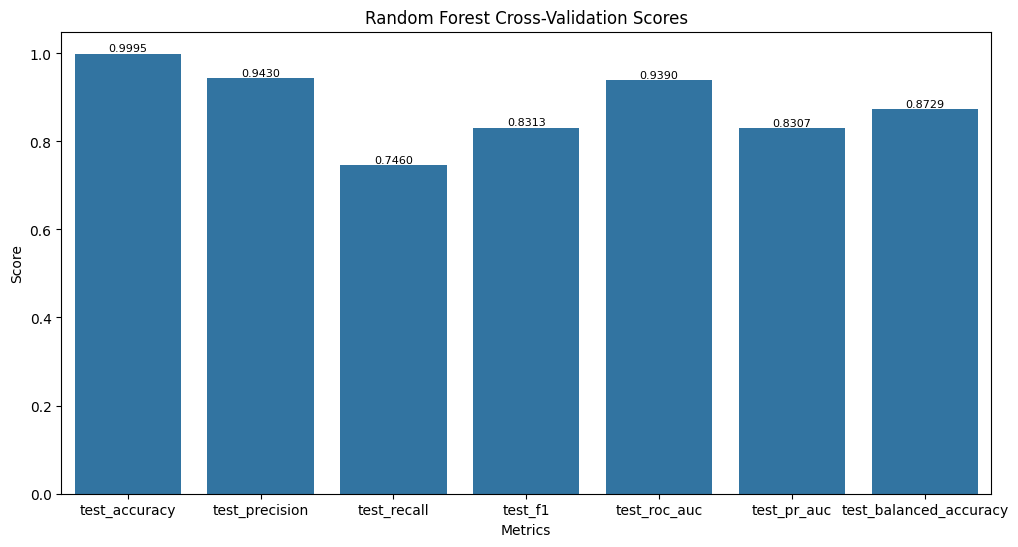

In [23]:
plt.figure(figsize=(12, 6))

# 📊 Bar plot for Random Forest metrics
rand_tree_scores_barplot = sns.barplot(data=results_rand_tree_df.loc['test_accuracy':])

# Annotate bars with their values
for patch in rand_tree_scores_barplot.patches:
    height = patch.get_height()
    rand_tree_scores_barplot.annotate(
        f'{height:.4f}',  # Format value
        (patch.get_x() + patch.get_width() / 2, height),  # Center annotation
        ha='center', va='bottom', fontsize=8, color='black'
    )

plt.title("Random Forest Cross-Validation Scores")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.show()


In [24]:
import numpy as np

importances = np.mean(
    [estimator.feature_importances_ for estimator in rf_cv_results['estimator']],
    axis=0
)

# 📊 Sort and display
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
feature_importances

v14              0.172549
v10              0.148340
v4               0.136755
v12              0.112018
v11              0.071735
v17              0.054438
v3               0.040774
v7               0.030518
v16              0.030307
v2               0.021677
v21              0.019105
v18              0.013955
amount_scaled    0.012585
v20              0.011799
v19              0.011302
v8               0.011293
v1               0.010279
v9               0.009012
v5               0.008464
v15              0.008267
v27              0.007612
v28              0.007361
v6               0.007174
v26              0.006899
v23              0.006892
v13              0.006643
v22              0.006320
v25              0.005766
time_scaled      0.005532
v24              0.004631
dtype: float64

C:\Users\José Victor\AppData\Local\Temp\ipykernel_3444\1651492526.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")


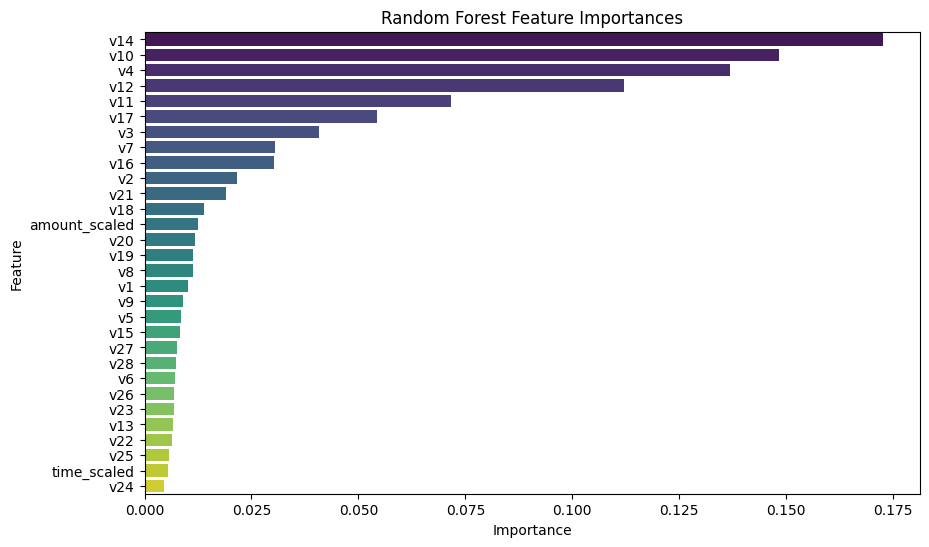

In [25]:
# 📉 Plot Feature Importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## 🌲 Random Forest Feature Importances

The analysis shows that a small subset of PCA-transformed features (notably V14, V10, V4, V12) carries most of the predictive signal for fraud detection. Features like `amount_scaled` have moderate importance, while `time_scaled` and several PCA features contribute little to model performance.

This suggests that fraud is characterized by patterns concentrated in a few principal components. However, Random Forest’s robustness to irrelevant features allows us to retain all features for now.


In [26]:
# lets try to speed training up by limiting training to top 5
features_to_use = feature_importances.index[0:5]

# 📊 Evaluate model
rf_quick_cv_results = cross_validate(
    rf_clf,
    X_train[features_to_use],
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# 📄 Display mean CV scores
for metric, scores in rf_quick_cv_results.items():
    if metric.startswith("test_"):
        print(f"{metric}: {scores.mean():.6f}")

results_quick_rand_tree_df = pd.DataFrame(rf_quick_cv_results)


test_accuracy: 0.999418
test_precision: 0.913730
test_recall: 0.719684
test_f1: 0.802624
test_roc_auc: 0.931352
test_pr_auc: 0.797999
test_balanced_accuracy: 0.859785


In [27]:
results_quick_rand_tree_df = pd.DataFrame(rf_quick_cv_results).mean(numeric_only=True)
results_quick_rand_tree_df.loc['test_accuracy':]

test_accuracy             0.999418
test_precision            0.913730
test_recall               0.719684
test_f1                   0.802624
test_roc_auc              0.931352
test_pr_auc               0.797999
test_balanced_accuracy    0.859785
dtype: float64

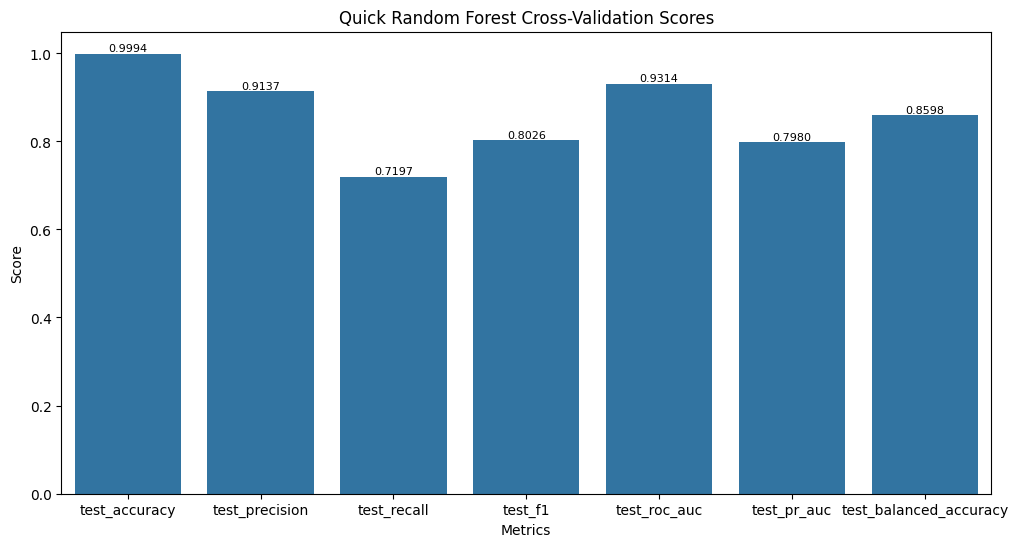

In [28]:
#plotting the quick version
plt.figure(figsize=(12, 6))

# 📊 Bar plot for Random Forest metrics
quick_rand_tree_scores_barplot = sns.barplot(data=results_quick_rand_tree_df.loc['test_accuracy':])

# Annotate bars with their values
for patch in quick_rand_tree_scores_barplot.patches:
    height = patch.get_height()
    quick_rand_tree_scores_barplot.annotate(
        f'{height:.4f}',  # Format value
        (patch.get_x() + patch.get_width() / 2, height),  # Center annotation
        ha='center', va='bottom', fontsize=8, color='black'
    )

plt.title("Quick Random Forest Cross-Validation Scores")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.show()


### Hyperparameter tuning with randomized search CV from sklearn


In [57]:


param_dist = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2", None],
}

rand_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=11037),
    param_distributions=param_dist,
    scoring='f1',
    n_iter=10,
    cv=cv,
    random_state=11037
)
rand_search.fit(X_train[features_to_use], y_train)


f

NameError: name 'features_to_use' is not defined

In [ ]:
print("Best parameters:", rand_search.best_params_)
print("F1_score for top model: ", rand_search.best_score_)

Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': None}
F1_score for top model:  0.8434483778021209


In [ ]:
tuned_rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    max_features='sqrt',
    max_depth=None,
    random_state=11037,
    class_weight='balanced',
    n_jobs=-1
)

In [ ]:
# eval the model with CV

tuned_rf_cv_results = cross_validate(
    tuned_rf_model,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

tuned_rf_results = pd.DataFrame(tuned_rf_cv_results).mean(numeric_only=True)

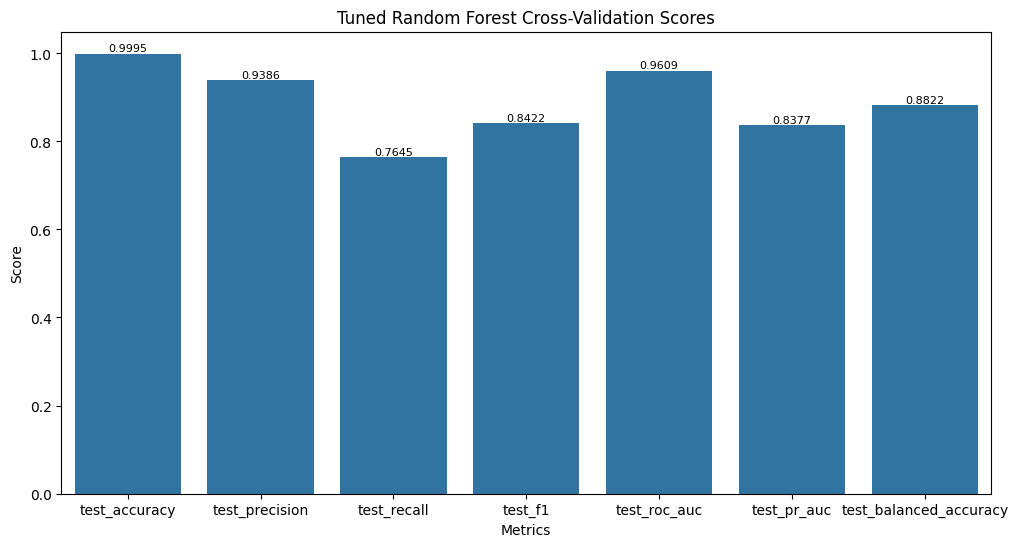

In [ ]:
plt.figure(figsize=(12, 6))

# 📊 Bar plot for Random Forest metrics
rf_tuned_scores_barplot = sns.barplot(data=tuned_rf_results.loc['test_accuracy':])

# Annotate bars with their values
for patch in rf_tuned_scores_barplot.patches:
    height = patch.get_height()
    rf_tuned_scores_barplot.annotate(
        f'{height:.4f}',  # Format value
        (patch.get_x() + patch.get_width() / 2, height),  # Center annotation
        ha='center', va='bottom', fontsize=8, color='black'
    )

plt.title("Tuned Random Forest Cross-Validation Scores")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.show()

### Now that we have found the best hyperparameters, lets train our *final* model on the whole training data

In [36]:
final_rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    max_features='sqrt',
    max_depth=None,
    random_state=11037,
    class_weight='balanced',
    n_jobs=-1
)

In [37]:
# train the model on the training data
final_rf_model.fit(X_train,y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

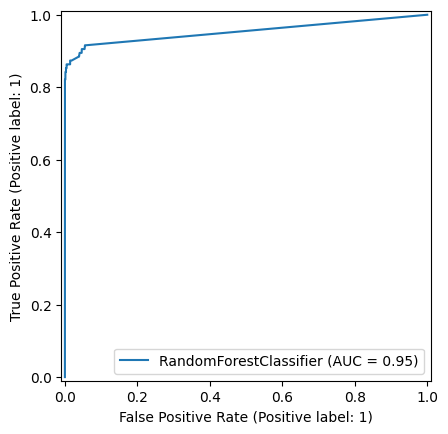

In [38]:
RocCurveDisplay.from_estimator(final_rf_model, X_test, y_test)
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix

In [39]:
y_pred = final_rf_model.predict(X_test)
final_model_cm = confusion_matrix(y_test,y_pred)
print(final_model_cm)

[[56649     2]
 [   24    71]]


In [40]:
from sklearn.metrics import check_scoring

In [41]:
scoring_call = check_scoring(estimator=final_rf_model, scoring=scoring, raise_exc=False)
scores = scoring_call(final_rf_model, X_test, y_test)

In [42]:
print(scores)

{'accuracy': 0.9995418179254926, 'precision': 0.9726027397260274, 'recall': 0.7473684210526316, 'f1': 0.8452380952380952, 'roc_auc': 0.9533989737720057, 'pr_auc': 0.8320884019424163, 'balanced_accuracy': 0.8736665585872503}


### finally, saving the final model using joblib

In [34]:
Path.cwd()

WindowsPath('e:/Programacao/LAPES/EDA_ML_DL_PS/LAPES-Data-Challenge-Predictive-Analytics-System/notebooks')

In [46]:
import joblib
file_path = Path.cwd().parent / 'models' / 'final_rf_model.pkl'
joblib.dump(final_rf_model, file_path)

print('model succesfully saved in', file_path)

model succesfully saved in e:\Programacao\LAPES\EDA_ML_DL_PS\LAPES-Data-Challenge-Predictive-Analytics-System\models\final_rf_model.pkl
